In [2]:
%load_ext tensorboard

In [3]:
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt
import datetime

In [4]:
# Load the dataset
data = pd.read_csv('Place Detail - V3 - With Detail (Scored).csv')

# Split the dataset into features (X) and labels (y)
X = data[['rating', 'total_reviews']]
y = data['score']

# Normalize the features
scaler = MinMaxScaler()
X_normalized = scaler.fit_transform(X)

# Split the normalized dataset into training, testing, and validation sets
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)


In [5]:
print(len(y_train))
print(len(y_test))
print(len(y_train))
print(len(y_val))
print(len(data))

3846
475
3846
428
4749


In [6]:
# Define the model architecture
model = tf.keras.Sequential([
    tf.keras.layers.Dense(512, activation='relu', input_shape=(2,)),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(1)
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')
#tf.keras.optimizers.RMSprop(learning_rate = 0.001)

In [7]:
# Train the model
#history = model.fit(train_dataset, epochs=100, validation_data = val_dataset)

log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val), callbacks=[tensorboard_callback])

Epoch 1/50
121/121 [==============================] - 3s 14ms/step - loss: 0.0109 - val_loss: 1.9809e-05
Epoch 2/50
121/121 [==============================] - 1s 11ms/step - loss: 2.5148e-06 - val_loss: 1.6238e-05
Epoch 3/50
121/121 [==============================] - 1s 11ms/step - loss: 1.0529e-06 - val_loss: 1.3729e-05
Epoch 4/50
121/121 [==============================] - 2s 13ms/step - loss: 5.2292e-07 - val_loss: 1.1757e-05
Epoch 5/50
121/121 [==============================] - 2s 13ms/step - loss: 2.0312e-07 - val_loss: 9.3554e-06
Epoch 6/50
121/121 [==============================] - 2s 16ms/step - loss: 9.3403e-08 - val_loss: 9.8204e-06
Epoch 7/50
121/121 [==============================] - 1s 11ms/step - loss: 1.0953e-07 - val_loss: 8.8373e-06
Epoch 8/50
121/121 [==============================] - 1s 10ms/step - loss: 7.7620e-08 - val_loss: 8.5126e-06
Epoch 9/50
121/121 [==============================] - 1s 11ms/step - loss: 9.7565e-08 - val_loss: 8.7736e-06
Epoch 10/50
121/121 [==

In [8]:
y_pred = model.predict(X_test)

# Calculate evaluation metrics (mean squared error and mean absolute error)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print('Mean Squared Error:', mse)
print('Mean Absolute Error:', mae)

# Evaluate the model's loss on the test set
loss = model.evaluate(X_test, y_test)
print('Test loss:', loss)


15/15 [==============================] - 0s 4ms/step
Mean Squared Error: 1.1567048605265738e-07
Mean Absolute Error: 0.00029461447185931286
15/15 [==============================] - 0s 4ms/step - loss: 1.1567e-07
Test loss: 1.1567170332682508e-07


In [9]:
new_data = pd.DataFrame({'rating': [5],'total_reviews': [15000]})

predictions = model.predict(new_data)

# Make predictions on the normalized new data
new_data_normalized = scaler.transform(new_data)
predictions = model.predict(new_data_normalized)

print('this is the prediction before normalized: ', model.predict(new_data))
print('this is the prediction after normalized: ', model.predict(new_data_normalized))

1/1 [==============================] - 0s 40ms/step
this is the prediction before normalized:  [[7566.1187]]
1/1 [==============================] - 0s 35ms/step
this is the prediction after normalized:  [[0.98484874]]


In [10]:
model.save('Scoring_Model.h5')

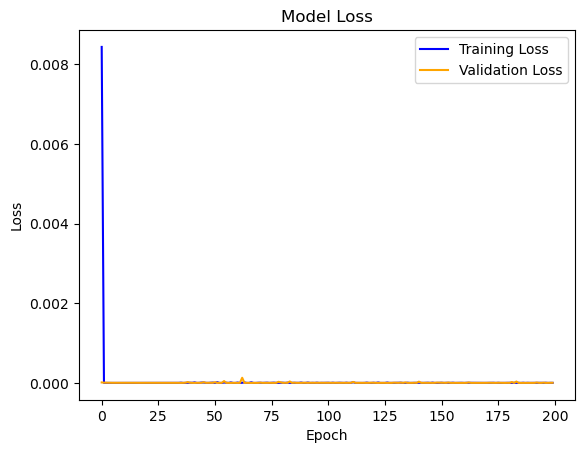

In [50]:
# Plot the training loss and validation loss
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
#plt.xlim(150, 200)
plt.show()

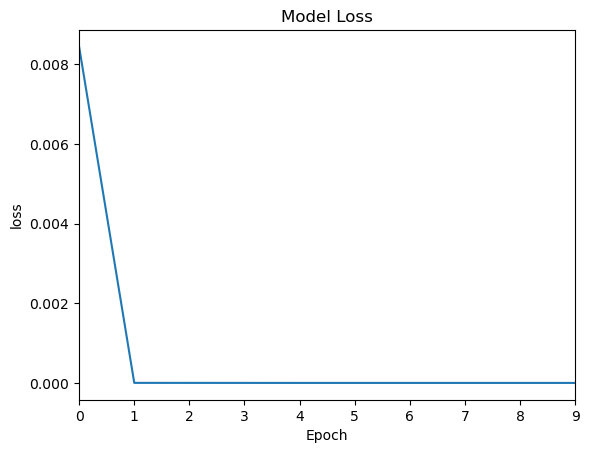

In [42]:
# Plot the training loss
plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
# plt.xlim()
plt.show()

In [1]:
%tensorboard --logdir logs/fit

UsageError: Line magic function `%tensorboard` not found.


In [44]:
# EXERCISE: Use the tf.saved_model API to save your model in the SavedModel format. 
export_dir = '/saved_model/1'

# YOUR CODE HERE
tf.saved_model.save(model, export_dir = export_dir)

INFO:tensorflow:Assets written to: /saved_model/1\assets


INFO:tensorflow:Assets written to: /saved_model/1\assets


In [45]:
# Select mode of optimization
mode = "Speed" 

if mode == 'Storage':
    optimization = tf.lite.Optimize.OPTIMIZE_FOR_SIZE
elif mode == 'Speed':
    optimization = tf.lite.Optimize.OPTIMIZE_FOR_LATENCY
else:
    optimization = tf.lite.Optimize.DEFAULT

In [46]:
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)

# Set the optimzations
converter.optimizations = [optimization]

# Invoke the converter to finally generate the TFLite model
tflite_model = converter.convert()

In [47]:
import pathlib

tflite_model_file = pathlib.Path('./model.tflite')
tflite_model_file.write_bytes(tflite_model)

138224